<a href="https://colab.research.google.com/github/MorrisC664/Amazon-Electronics-Product-Analysis/blob/main/amazon_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#install packages
!pip install requests beautifulsoup4 textblob wordcloud reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.9 MB/s eta 0:00:00


In [3]:
# Core modules
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP tools
from textblob import TextBlob
from wordcloud import WordCloud

# PDF output
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch

# Settings
pd.set_option('display.max_colwidth', 100)
sns.set(style='whitegrid')


In [4]:
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}


In [6]:
#test the link
url = "https://www.amazon.com/Best-Sellers-Electronics/zgbs/electronics"
response = requests.get(url, headers=headers)

# Show status and preview HTML
print("Status Code:", response.status_code)
print(response.text[:1000])


Status Code: 200
<!doctype html><html lang="en-us" class="a-no-js" data-19ax5a9jf="dingo"><!-- sp:feature:head-start -->
<head><script>var aPageStart = (new Date()).getTime();</script><meta charset="utf-8"/>
<!-- sp:end-feature:head-start -->
<!-- sp:feature:csm:head-open-part1 -->

<script type='text/javascript'>var ue_t0=ue_t0||+new Date();</script>
<!-- sp:end-feature:csm:head-open-part1 -->
<!-- sp:feature:cs-optimization -->
<meta http-equiv='x-dns-prefetch-control' content='on'>
<link rel="dns-prefetch" href="https://images-na.ssl-images-amazon.com">
<link rel="dns-prefetch" href="https://m.media-amazon.com">
<link rel="dns-prefetch" href="https://completion.amazon.com">
<!-- sp:end-feature:cs-optimization -->
<!-- sp:feature:csm:head-open-part2 -->
<script type='text/javascript'>
window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new D

In [12]:
#get the product information
def scrape_amazon_bestsellers(url, headers, max_items=20):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    products = []
    count = 0

    for item in soup.select("div.zg-grid-general-faceout"):
        if count >= max_items:
            break

        # Extract title
        title_tag = item.select_one("div.p13n-sc-truncate-desktop-type2, div._cDEzb_p13n-sc-css-line-clamp-3_g3dy1")
        title = title_tag.text.strip() if title_tag else "N/A"

        # Extract product URL
        link_tag = item.find("a", href=True)
        product_url = "https://www.amazon.com" + link_tag["href"] if link_tag else "N/A"

        # Extract rating
        rating_tag = item.select_one("span.a-icon-alt")
        rating = rating_tag.text.split()[0] if rating_tag else "N/A"

        # Extract number of reviews
        review_tag = item.select_one("span.a-size-small")
        num_reviews = review_tag.text.strip().replace(",", "") if review_tag else "0"

        # Extract price
        def extract_price(item):
            # Indented the lines within the function
            price_tag = item.select_one("span.p13n-sc-price")
            if not price_tag:
                price_tag = item.select_one("span.a-price-whole")
            if not price_tag:
                price_tag = item.select_one("span.a-color-price")
            return price_tag.text.replace("$", "").strip() if price_tag else "N/A"

        price = extract_price(item) # Call the function and assign the result to price


        products.append({
            "Title": title,
            "URL": product_url,
            "Rating": rating,
            "Reviews": int(num_reviews),
            "Price (USD)": price
        })

        count += 1

    return pd.DataFrame(products)


In [13]:
#check if we could get the product information correctly
url = "https://www.amazon.com/Best-Sellers-Electronics/zgbs/electronics"
df_products = scrape_amazon_bestsellers(url, headers, max_items=20)

# Show preview
df_products.head()


,Title,URL,Rating,Reviews,Price (USD)
0,"Amazon Fire TV Stick HD (newest model), free and live TV, Alexa Voice Remote, smart home control...",https://www.amazon.com/amazon-fire-tv-stick-hd/dp/B0CQMRKRV5/ref=zg_bs_g_electronics_d_sccl_1/14...,4.6,11818,19.99
1,Apple AirTag,https://www.amazon.com/Apple-MX532LL-A-AirTag/dp/B0CWXNS552/ref=zg_bs_g_electronics_d_sccl_2/146...,4.6,26475,24.95
2,"Apple AirPods Pro 2 Wireless Earbuds, Bluetooth Headphones, Active Noise Cancellation, Hearing A...",https://www.amazon.com/Apple-Cancellation-Transparency-Personalized-High-Fidelity/dp/B0D1XD1ZV3/...,4.6,24557,189.99
3,Apple AirTag 4 Pack,https://www.amazon.com/Apple-MX542LL-A-AirTag-Pack/dp/B0D54JZTHY/ref=zg_bs_g_electronics_d_sccl_...,4.7,18801,79.98
4,"Amazon Fire TV Stick 4K (newest model) with AI-powered Fire TV Search, Wi-Fi 6, stream over 1.5 ...",https://www.amazon.com/Amazon-Fire-TV-Stick-4K-streaming-device/dp/B0CJM1GNFQ/ref=zg_bs_g_electr...,4.7,63184,29.99


In [14]:
# Convert price and rating to numeric
df_products["Price (USD)"] = pd.to_numeric(df_products["Price (USD)"], errors="coerce")
df_products["Rating"] = pd.to_numeric(df_products["Rating"], errors="coerce")


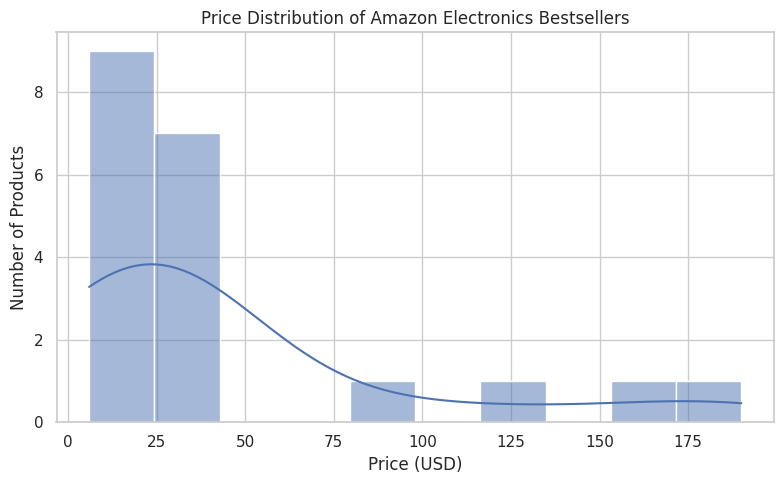

In [15]:
#plot price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_products["Price (USD)"].dropna(), bins=10, kde=True)
plt.title("Price Distribution of Amazon Electronics Bestsellers")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()


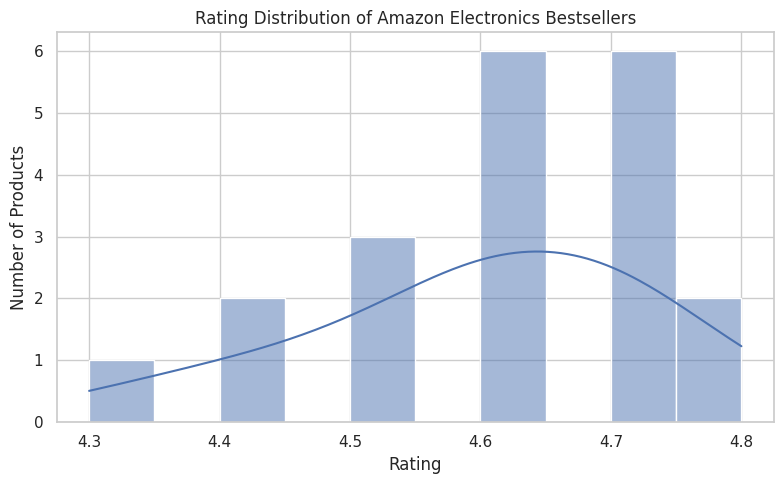

In [16]:
#plot rating distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_products["Rating"].dropna(), bins=10, kde=True)
plt.title("Rating Distribution of Amazon Electronics Bestsellers")
plt.xlabel("Rating")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()


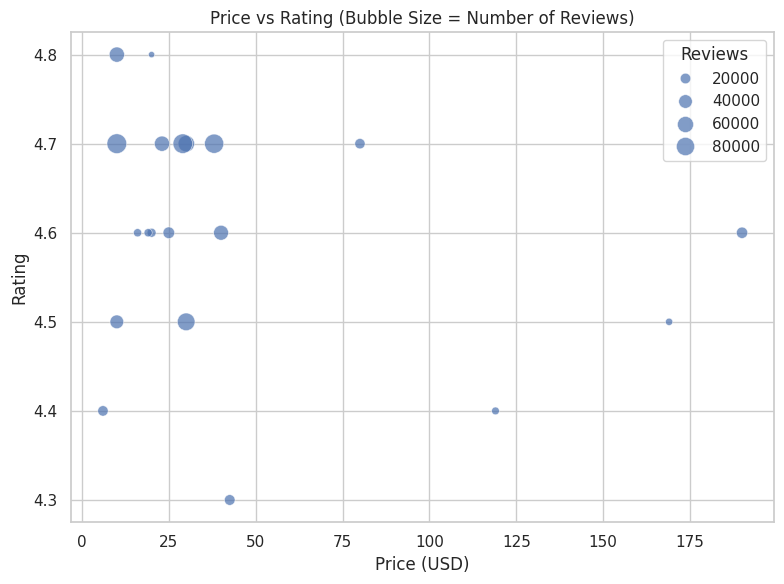

In [17]:
#plot price vs rating with reviews
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Price (USD)", y="Rating", size="Reviews", sizes=(20, 200), alpha=0.7)
plt.title("Price vs Rating (Bubble Size = Number of Reviews)")
plt.xlabel("Price (USD)")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


In [18]:
# Ensure numerical format
df_products["Price (USD)"] = pd.to_numeric(df_products["Price (USD)"], errors="coerce")
df_products["Rating"] = pd.to_numeric(df_products["Rating"], errors="coerce")
df_products["Reviews"] = pd.to_numeric(df_products["Reviews"], errors="coerce")

# Add a new column: title length
df_products["Title Length"] = df_products["Title"].apply(lambda x: len(x))


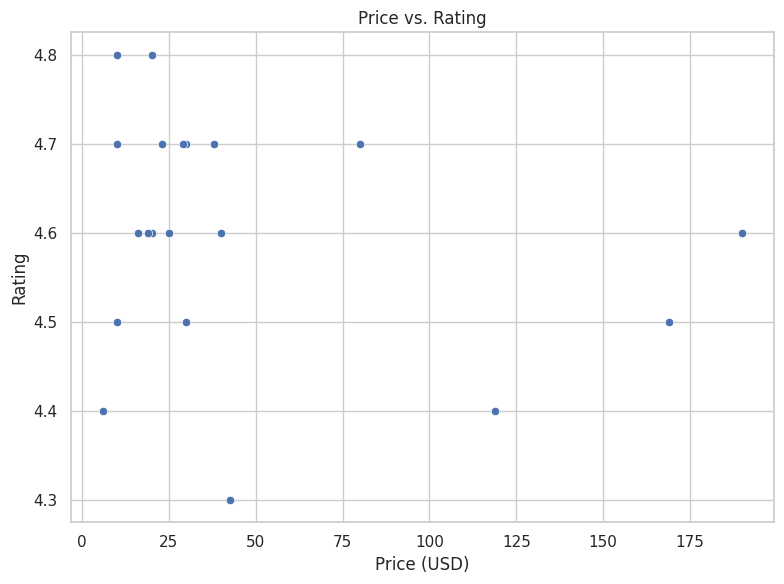

In [19]:
#plot price vs rating
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Price (USD)", y="Rating")
plt.title("Price vs. Rating")
plt.xlabel("Price (USD)")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


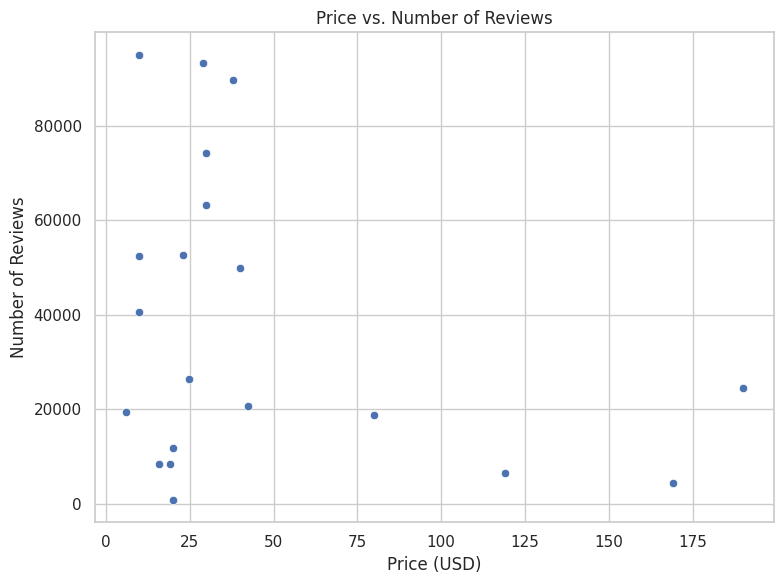

In [20]:
#plot price vs reviews
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Price (USD)", y="Reviews")
plt.title("Price vs. Number of Reviews")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


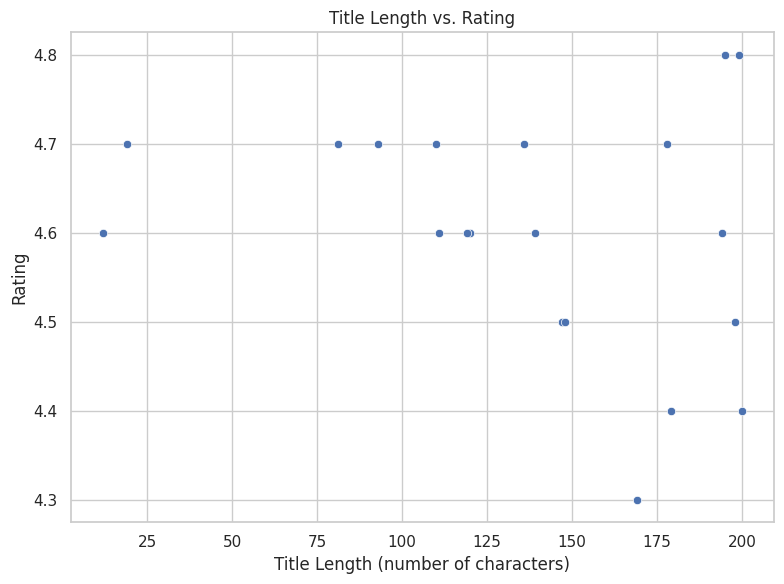

In [21]:
#plot title vs rating
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Title Length", y="Rating")
plt.title("Title Length vs. Rating")
plt.xlabel("Title Length (number of characters)")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


In [22]:
# Drop NA rows to ensure valid scoring
df_ranked = df_products.dropna(subset=["Rating", "Reviews", "Price (USD)"]).copy()

# Normalize all metrics to 0~1 range
df_ranked["Score_Rating"] = df_ranked["Rating"] / df_ranked["Rating"].max()
df_ranked["Score_Reviews"] = df_ranked["Reviews"] / df_ranked["Reviews"].max()
df_ranked["Score_Price"] = 1 - (df_ranked["Price (USD)"] / df_ranked["Price (USD)"].max())  # Lower price = higher score

# Compute final score with weighted average
df_ranked["Composite Score"] = (
    0.5 * df_ranked["Score_Rating"] +
    0.3 * df_ranked["Score_Reviews"] +
    0.2 * df_ranked["Score_Price"]
)

# Sort products by composite score
df_ranked = df_ranked.sort_values(by="Composite Score", ascending=False)
df_ranked.reset_index(drop=True, inplace=True)


In [23]:
df_ranked[["Title", "Price (USD)", "Rating", "Reviews", "Composite Score"]].head(5)


,Title,Price (USD),Rating,Reviews,Composite Score
0,"Wall Charger, Surge Protector, QINLIANF 5 Outlet Extender with 4 USB Charging Ports (4.8A Total)...",9.98,4.7,95113,0.979078
1,"Roku Express 4K+ | Roku Streaming Device 4K/HDR with Voice Remote, Free & Live TV",28.97,4.7,93236,0.953167
2,"Roku Streaming Stick 4K | Portable Roku Streaming Device 4K/HDR/Dolby Vision with Voice Remote, ...",38.00,4.7,89699,0.932505
3,"JBL Tune 510BT - Bluetooth headphones with up to 40 hours battery, microphone for call, foldable...",29.95,4.5,74339,0.871698
4,"Amazon Fire TV Stick 4K (newest model) with AI-powered Fire TV Search, Wi-Fi 6, stream over 1.5 ...",29.99,4.7,63184,0.857305


In [24]:
#recommendation summary
def summarize_product(row):
    return f"• {row['Title']}\n  - Price: ${row['Price (USD)']:.2f}\n  - Rating: {row['Rating']} ({row['Reviews']} reviews)"

top5_cards = df_ranked.head(5).apply(summarize_product, axis=1)

for i, card in enumerate(top5_cards, 1):
    print(f"Recommendation #{i}:\n{card}\n")


Recommendation #1:
• Wall Charger, Surge Protector, QINLIANF 5 Outlet Extender with 4 USB Charging Ports (4.8A Total) 3-Sided 1680J Power Strip Multi Plug Adapter Spaced for Home Travel Office (3U1C)
  - Price: $9.98
  - Rating: 4.7 (95113 reviews)

Recommendation #2:
• Roku Express 4K+ | Roku Streaming Device 4K/HDR with Voice Remote, Free & Live TV
  - Price: $28.97
  - Rating: 4.7 (93236 reviews)

Recommendation #3:
• Roku Streaming Stick 4K | Portable Roku Streaming Device 4K/HDR/Dolby Vision with Voice Remote, Free & Live TV
  - Price: $38.00
  - Rating: 4.7 (89699 reviews)

Recommendation #4:
• JBL Tune 510BT - Bluetooth headphones with up to 40 hours battery, microphone for call, foldable and comfortable, Android and iOs compatible (Black)
  - Price: $29.95
  - Rating: 4.5 (74339 reviews)

Recommendation #5:
• Amazon Fire TV Stick 4K (newest model) with AI-powered Fire TV Search, Wi-Fi 6, stream over 1.5 million movies and shows, free & live TV
  - Price: $29.99
  - Rating: 4.7 

In [25]:
# price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_products["Price (USD)"].dropna(), bins=10, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("price_distribution.png")
plt.close()


In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(df_products["Rating"].dropna(), bins=10, kde=True)
plt.title("Rating Distribution of Amazon Electronics Bestsellers")
plt.xlabel("Rating")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.savefig("rating_distribution.png")
plt.close()


In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Price (USD)", y="Rating")
plt.title("Price vs. Rating")
plt.xlabel("Price (USD)")
plt.ylabel("Rating")
plt.tight_layout()
plt.savefig("price_vs_rating.png")
plt.close()


In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Price (USD)", y="Reviews")
plt.title("Price vs. Number of Reviews")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.savefig("price_vs_reviews.png")
plt.close()


In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x="Title Length", y="Rating")
plt.title("Title Length vs. Rating")
plt.xlabel("Title Length (number of characters)")
plt.ylabel("Rating")
plt.tight_layout()
plt.savefig("title_length_vs_rating.png")
plt.close()


In [31]:
#create pdf report
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def generate_pdf_report(filename="Amazon_Electronics_Report.pdf"):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter

    # Title
    c.setFont("Helvetica-Bold", 20)
    c.drawString(50, height - 60, "Amazon Electronics Bestseller Analysis Report")

    # Section 1 - Price Distribution Chart
    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, height - 100, "1. Price Distribution")
    c.drawImage("price_distribution.png", 50, height - 400, width=500, height=250)

    # Section 2 - Rating Distribution
    c.drawString(50, height - 430, "2. Rating Distribution")
    c.drawImage("rating_distribution.png", 50, height - 730, width=500, height=250)

    c.showPage()

    # Section 3 - Scatter Plots
    c.drawString(50, height - 60, "3. Price vs Rating")
    c.drawImage("price_vs_rating.png", 50, height - 350, width=500, height=250)

    c.drawString(50, height - 380, "4. Price vs Reviews")
    c.drawImage("price_vs_reviews.png", 50, height - 670, width=500, height=250)

    c.showPage()

    # Section 4 - Product Recommendations
    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, height - 60, "5. Top Product Recommendations")

    c.setFont("Helvetica", 11)
    y = height - 90
    for i, row in df_ranked.head(5).iterrows():
        c.drawString(60, y, f"{i+1}. {row['Title'][:80]}")
        y -= 20
        c.drawString(80, y, f"   Price: ${row['Price (USD)']:.2f}, Rating: {row['Rating']}, Reviews: {row['Reviews']}")
        y -= 30
        if y < 100:
            c.showPage()
            y = height - 60

    c.save()

generate_pdf_report()


In [32]:
#download pdf report
from google.colab import files
files.download("Amazon_Electronics_Report.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>